<a href="https://colab.research.google.com/github/Belvinbarasa/Eng.barasa/blob/main/Robot_Navigation_using_Deep_Q_Learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym
!pip install matplotlib
!pip install streamlit
!pip install pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00


In [ ]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class GridWorldEnv(gym.Env):
    def __init__(self, grid_size=5):
        super(GridWorldEnv, self).__init__()
        self.grid_size = grid_size
        self.action_space = gym.spaces.Discrete(4)  # up, down, left, right
        self.observation_space = gym.spaces.Box(low=0, high=grid_size-1, shape=(2,), dtype=np.int32)
        self.reset()

    def reset(self):
        self.agent_pos = np.array([0, 0])
        self.goal_pos = np.array([self.grid_size-1, self.grid_size-1])
        return self.agent_pos.copy()

    def step(self, action):
        if action == 0 and self.agent_pos[0] > 0: self.agent_pos[0] -= 1
        elif action == 1 and self.agent_pos[0] < self.grid_size-1: self.agent_pos[0] += 1
        elif action == 2 and self.agent_pos[1] > 0: self.agent_pos[1] -= 1
        elif action == 3 and self.agent_pos[1] < self.grid_size-1: self.agent_pos[1] += 1

        done = np.array_equal(self.agent_pos, self.goal_pos)
        reward = 10 if done else -1

        return self.agent_pos.copy(), reward, done, {}

    def render(self):
        grid = np.full((self.grid_size, self.grid_size), '.')
        grid[self.goal_pos[0], self.goal_pos[1]] = 'G'
        grid[self.agent_pos[0], self.agent_pos[1]] = 'A'
        for row in grid:
            print(' '.join(row))
        print()

env = GridWorldEnv(grid_size=5)
env.render()


A . . . .
. . . . .
. . . . .
. . . . .
. . . . G



In [ ]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 500
LR = 1e-3
BATCH_SIZE = 64
TARGET_UPDATE = 10
MEMORY_SIZE = 10000
NUM_EPISODES = 300

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def select_action(state, policy_net, steps_done):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).max(1)[1].item()
    else:
        return random.randrange(env.action_space.n)


In [ ]:
policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(MEMORY_SIZE)

steps_done = 0
episode_rewards = []

for episode in range(NUM_EPISODES):
    state = env.reset()
    total_reward = 0
    for t in range(100):
        action = select_action(state, policy_net, steps_done)
        next_state, reward, done, _ = env.step(action)
        memory.push((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        steps_done += 1

        if len(memory) >= BATCH_SIZE:
            transitions = memory.sample(BATCH_SIZE)
            batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

            batch_state = torch.FloatTensor(batch_state).to(device)
            batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(device)
            batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
            batch_next_state = torch.FloatTensor(batch_next_state).to(device)
            batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

            q_values = policy_net(batch_state).gather(1, batch_action)
            next_q_values = target_net(batch_next_state).max(1)[0].detach().unsqueeze(1)
            expected_q_values = batch_reward + (GAMMA * next_q_values * (1 - batch_done))

            loss = nn.MSELoss()(q_values, expected_q_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    episode_rewards.append(total_reward)

    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print("Training finished!")


<ipython-input-5-32abab789d96>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch_state = torch.FloatTensor(batch_state).to(device)


Training finished!


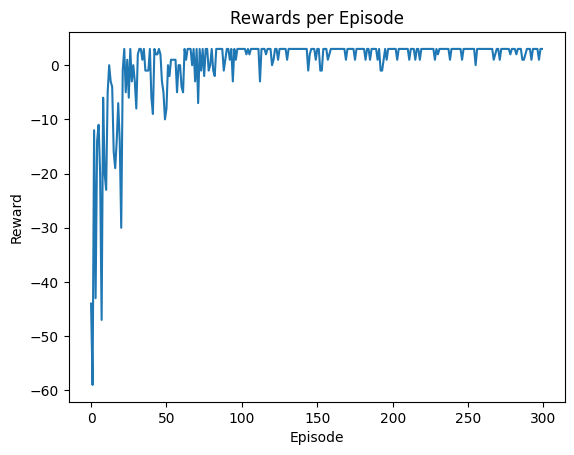

In [ ]:
plt.plot(episode_rewards)
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()


In [ ]:
state = env.reset()
done = False
env.render()

while not done:
    action = policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).max(1)[1].item()
    state, _, done, _ = env.step(action)
    env.render()


A . . . .
. . . . .
. . . . .
. . . . .
. . . . G

. . . . .
A . . . .
. . . . .
. . . . .
. . . . G

. . . . .
. . . . .
A . . . .
. . . . .
. . . . G

. . . . .
. . . . .
. . . . .
A . . . .
. . . . G

. . . . .
. . . . .
. . . . .
. A . . .
. . . . G

. . . . .
. . . . .
. . . . .
. . A . .
. . . . G

. . . . .
. . . . .
. . . . .
. . . A .
. . . . G

. . . . .
. . . . .
. . . . .
. . . . A
. . . . G

. . . . .
. . . . .
. . . . .
. . . . .
. . . . A



In [ ]:
import streamlit as st
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from pyngrok import ngrok
import time
from PIL import Image
import io

# Set up the page
st.set_page_config(page_title="GridWorld DQN Agent", layout="wide")
st.title("🧭 GridWorld DQN Agent")
st.markdown("""
This interactive app trains a Deep Q-Network (DQN) agent to navigate a GridWorld environment.
""")

# Sidebar for controls
with st.sidebar:
    st.header("⚙️ Parameters")
    grid_size = st.slider("Grid Size", 3, 10, 5)
    num_episodes = st.slider("Number of Episodes", 100, 1000, 300, 100)
    learning_rate = st.slider("Learning Rate", 0.0001, 0.01, 0.001, 0.0001)
    batch_size = st.slider("Batch Size", 16, 128, 64, 16)
    gamma = st.slider("Discount Factor (Gamma)", 0.9, 0.999, 0.99, 0.01)
    eps_start = st.slider("Epsilon Start", 0.1, 1.0, 1.0, 0.1)
    eps_end = st.slider("Epsilon End", 0.01, 0.2, 0.05, 0.01)
    eps_decay = st.slider("Epsilon Decay", 100, 1000, 500, 100)

    train_button = st.button("🚀 Train Agent")
    visualize_button = st.button("👀 Visualize Trained Agent")

# Environment class
class GridWorldEnv(gym.Env):
    def __init__(self, grid_size=5):
        super(GridWorldEnv, self).__init__()
        self.grid_size = grid_size
        self.action_space = gym.spaces.Discrete(4)  # up, down, left, right
        self.observation_space = gym.spaces.Box(low=0, high=grid_size-1, shape=(2,), dtype=np.int32)
        self.reset()

    def reset(self):
        self.agent_pos = np.array([0, 0])
        self.goal_pos = np.array([self.grid_size-1, self.grid_size-1])
        return self.agent_pos.copy()

    def step(self, action):
        if action == 0 and self.agent_pos[0] > 0: self.agent_pos[0] -= 1
        elif action == 1 and self.agent_pos[0] < self.grid_size-1: self.agent_pos[0] += 1
        elif action == 2 and self.agent_pos[1] > 0: self.agent_pos[1] -= 1
        elif action == 3 and self.agent_pos[1] < self.grid_size-1: self.agent_pos[1] += 1

        done = np.array_equal(self.agent_pos, self.goal_pos)
        reward = 10 if done else -1

        return self.agent_pos.copy(), reward, done, {}

    def render(self, return_image=False):
        grid = np.full((self.grid_size, self.grid_size, 3), 255, dtype=np.uint8)

        # Goal position (green)
        grid[self.goal_pos[0], self.goal_pos[1]] = [0, 255, 0]

        # Agent position (blue)
        grid[self.agent_pos[0], self.agent_pos[1]] = [0, 0, 255]

        # Create grid lines
        grid[::, :1] = [200, 200, 200]
        grid[::1, :1] = [200, 200, 200]

        if return_image:
            img = Image.fromarray(grid)
            img = img.resize((300, 300), Image.NEAREST)
            return img
        else:
            plt.imshow(grid)
            plt.axis('off')
            plt.show()

# DQN Network
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def select_action(state, policy_net, steps_done, eps_end, eps_start, eps_decay):
    eps_threshold = eps_end + (eps_start - eps_end) * np.exp(-1. * steps_done / eps_decay)
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).max(1)[1].item()
    else:
        return random.randrange(env.action_space.n)

# Initialize environment and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = GridWorldEnv(grid_size=grid_size)

# Training function
def train_agent():
    policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    memory = ReplayMemory(10000)

    steps_done = 0
    episode_rewards = []

    progress_bar = st.progress(0)
    status_text = st.empty()
    reward_plot = st.empty()
    env_display = st.empty()

    fig, ax = plt.subplots()

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for t in range(100):
            action = select_action(state, policy_net, steps_done, eps_end, eps_start, eps_decay)
            next_state, reward, done, _ = env.step(action)
            memory.push((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            steps_done += 1

            if len(memory) >= batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.FloatTensor(batch_state).to(device)
                batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(device)
                batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
                batch_next_state = torch.FloatTensor(batch_next_state).to(device)
                batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

                q_values = policy_net(batch_state).gather(1, batch_action)
                next_q_values = target_net(batch_next_state).max(1)[0].detach().unsqueeze(1)
                expected_q_values = batch_reward + (gamma * next_q_values * (1 - batch_done))

                loss = nn.MSELoss()(q_values, expected_q_values)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        episode_rewards.append(total_reward)

        # Update plots and status
        progress_bar.progress((episode + 1) / num_episodes)
        status_text.text(f"Episode: {episode + 1}/{num_episodes} | Reward: {total_reward:.2f}")

        # Update reward plot every 10 episodes
        if episode % 10 == 0 or episode == num_episodes - 1:
            ax.clear()
            ax.plot(episode_rewards)
            ax.set_title('Rewards per Episode')
            ax.set_xlabel('Episode')
            ax.set_ylabel('Reward')
            reward_plot.pyplot(fig)

        # Show environment every 50 episodes
        if episode % 50 == 0 or episode == num_episodes - 1:
            img = env.render(return_image=True)
            env_display.image(img, caption=f"Episode {episode + 1}")

        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

    st.success("Training completed!")
    return policy_net

# Visualization function
def visualize_agent(policy_net):
    state = env.reset()
    done = False

    visualization_placeholder = st.empty()
    status_text = st.empty()

    while not done:
        img = env.render(return_image=True)
        visualization_placeholder.image(img, caption="Current State")

        with torch.no_grad():
            action = policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).max(1)[1].item()

        state, _, done, _ = env.step(action)
        status_text.text(f"Agent Position: {state} | Action: {['Up', 'Down', 'Left', 'Right'][action]}")
        time.sleep(0.5)

    img = env.render(return_image=True)
    visualization_placeholder.image(img, caption="Final State - Goal Reached!")
    st.balloons()

# Main app logic
if train_button:
    st.session_state.policy_net = train_agent()

if visualize_button and 'policy_net' in st.session_state:
    visualize_agent(st.session_state.policy_net)
elif visualize_button:
    st.warning("Please train the agent first!")

ModuleNotFoundError: No module named 'streamlit'